## Importing the libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error

## Reading in the data file

In [2]:
df_listings = pd.read_csv('Data/listings.csv', dtype={'listing_url': 'object',
                                                      'price': 'object',
                                                      'weekly_price': 'object',
                                                      'monthly_price': 'object',
                                                      'security_deposit': 'object',
                                                      'cleaning_fee': 'object',
                                                      'extra_people': 'object',
                                                      'license': 'object', 
                                                      'jurisdiction_names': 'object',})

In [3]:
df_listings.shape

(86358, 106)

In [4]:
pd.set_option('display.max_columns', None)

# show listings data sample
df_listings.head(3)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,13913,https://www.airbnb.com/rooms/13913,20200414180850,2020-04-16,Holiday London DB Room Let-on going,My bright double bedroom with a large window h...,"Hello Everyone, I'm offering my lovely double ...",My bright double bedroom with a large window h...,business,Finsbury Park is a friendly melting pot commun...,For art lovers I can give guest my Tate Member...,The flat only a 10 minute walk to Finsbury Par...,Guest will have access to the self catering ki...,I like to have little chats with my guest over...,I'm an artist and have my artwork up on the wa...,NaN,NaN,https://a0.muscache.com/im/pictures/ffb507b7-9...,NaN,54730,https://www.airbnb.com/users/show/54730,Alina,2009-11-16,"London, England, United Kingdom",I am a Multi-Media Visual Artist and Creative ...,within a few hours,71%,89%,f,https://a0.muscache.com/im/users/54730/profile...,https://a0.muscache.com/im/users/54730/profile...,LB of Islington,4.0,4.0,"['email', 'phone', 'facebook', 'reviews', 'off...",t,t,"Islington, Greater London, United Kingdom",LB of Islington,Islington,NaN,Islington,Greater London,N4 3,London,"Islington, United Kingdom",GB,United Kingdom,51.56802,-0.11121,t,Apartment,Private room,2,1.0,1.0,0.0,Real Bed,"{TV,""Cable TV"",Wifi,Kitchen,""Paid parking off ...",538.0,$65.00,$333.00,"$1,176.00",$100.00,$15.00,1,$15.00,1,29,1,1,29,29,1.0,29.0,12 months ago,t,27,57,84,359,2020-04-16,21,7,2010-08-18,2020-02-22,97.0,10.0,10.0,10.0,10.0,9.0,9.0,f,NaN,NaN,f,f,moderate,f,f,2,1,1,0,0.18
1,15400,https://www.airbnb.com/rooms/15400,20200414180850,2020-04-16,Bright Chelsea Apartment. Chelsea!,Lots of windows and light. St Luke's Gardens ...,Bright Chelsea Apartment This is a bright one...,Lots of windows and light. St Luke's Gardens ...,romantic,It is Chelsea.,The building next door is in the process of be...,The underground stations are South Kensington ...,There are two wardrobes for guests exclusive u...,If I am in the country I like to welcome my gu...,NO SMOKING PLEASE.. No unauthorised guests. No...,NaN,NaN,https://a0.muscache.com/im/pictures/428392/462...,NaN,60302,https://www.airbnb.com/users/show/60302,Philippa,2009-12-05,"Kensington, England, United Kingdom","English, grandmother, I have travelled quite ...",within a day,50%,67%,f,https://a0.musc

In [5]:
class format_data:
    
    def __init__(self, dataframe):
        self.dataframe = dataframe
        
    def data_float(self):
        self = self.str.replace('$', '', regex=True).replace(',', '', regex=True).astype(float)
        
        return self
    
    def data_percentage(self):
        self = (self.str.replace('%', '', regex=True).astype('float')) / 100
        
        return self

In [6]:
#format_data.data_float(df_listings['price'])

float_list = ['price','security_deposit','cleaning_fee','extra_people']
for x in float_list:
    df_listings[x] = format_data.data_float(df_listings[x])

In [7]:
float_list = ['host_response_rate','host_acceptance_rate']
for x in float_list:
    df_listings[x] = format_data.data_percentage(df_listings[x])

## Data Exploration

In [8]:
df_listings.describe()

,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_response_rate,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,availability_30,availability_60,availability_90,availability_365,number_of_reviews,number_of_reviews_ltm,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,8.635800e+04,8.635800e+04,0.0,0.0,0.0,8.635800e+04,53473.000000,64813.000000,86348.000000,86348.000000,0.0,86358.000000,86358.000000,86358.000000,86226.000000,86216.000000,85416.000000,378.000000,86358.000000,56676.000000,64465.000000,86358.000000,86358.000000,86358.000000,8.635800e+04,86358.000000,86358.000000,8.635800e+04,8.635800e+04,86358.000000,8.635800e+04,86358.000000,86358.000000,86358.000000,86358.000000,86358.000000,86358.000000,63201.000000,63140.000000,63150.000000,63091.000000,63145.000000,63092.000000,63091.000000,86358.000000,86358.000000,86358.000000,86358.000000,64842.000000
mean,2.511516e+07,2.020041e+13,NaN,NaN,NaN,9.334733e+07,0.926660,0.830196,25.805450,25.805450,NaN,51.509916,-0.128245,3.211793,1.312122,1.415399,1.756580,643.611111,129.610725,191.465806,43.886109,1.610760,7.339644,4.474490,1.859559e+04,4.611142,5.812895,4.352354e+04,6.403469e+05,5.213305,6.099044e+05,7.870944,20.663239,33.379201,116.328898,17.531277,6.039417,92.491938,9.498464,9.256089,9.619375,9.642949,9.545346,9.253428,20.987448,17.973506,2.392390,0.052224,0.963183
std,1.238307e+07,0.000000e+00,NaN,NaN,NaN,9.543753e+07,0.183485,0.254690,134.219607,134.219607,NaN,0.046204,0.093286,2.033954,0.611861,0.920860,1.291133,849.684376,289.484146,322.896383,46.501627,1.368455,14.194697,19.151568,3.843374e+06,25.141390,29.128662,8.256667e+06,3.673454e+07,27.244416,3.496024e+07,10.379774,22.536341,35.047341,135.293902,37.393948,11.836707,10.357702,1.007258,1.156111,0.917570,0.913096,0.834854,1.057238,100.232081,98.678139,13.027134,0.712945,1.177591
min,1.391300e+04,2.020041e+13,NaN,NaN,NaN,4.775000e+03,0.000000,0.000000,0.000000,0.000000,NaN,51.294790,-0.510310,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00,1.000000e+00,1.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,1.553035e+07,2.020041e+13,NaN,NaN,NaN,1.636343e+07,0.950000,0.760000,1.000000,1.000000,NaN,51.485850,-0.188380,2.000000,1.000000,1.000000,1.000000,130.000000,47.000000,0.000000,15.000000,1.000000,0.000000,1.000000,3.100000e+01,1.000000,1.000000,6.000000e+01,9.000000e+01,1.000000,8.500000e+01,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,90.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,0.000000,0.000000,0.000000,0.200000
50%,2.573346e+07,2.020041e+13,NaN,NaN,NaN,5.013476e+07,1.000000,0.960000,1.000000,1.000000,NaN,51.514080,-0.126245,2.000000,1.000000,1.000000,1.000000,522.000000,83.000000,100.000000,30.000000,1.000000,0.000000,2.000000,1.125000e+03,2.000000,2.000000,1.125000e+03,1.125000e+03,2.000000,1.125000e+03,0.000000,8.000000,16.000000,63.000000,4.000000,1.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,1.000000,0.000000,0.560000
75%,3.654165e+07,2.020041e+13,NaN,NaN,NaN,1.522947e+08,1.000000,1.000000,5.000000,5.000000,NaN,51.537620,-0.069930,4.000000,1.

In [9]:
set(df_listings.columns[df_listings.isnull().mean()>0.75])

{'jurisdiction_names',
 'license',
 'medium_url',
 'monthly_price',
 'neighbourhood_group_cleansed',
 'square_feet',
 'thumbnail_url',
 'weekly_price',
 'xl_picture_url'}

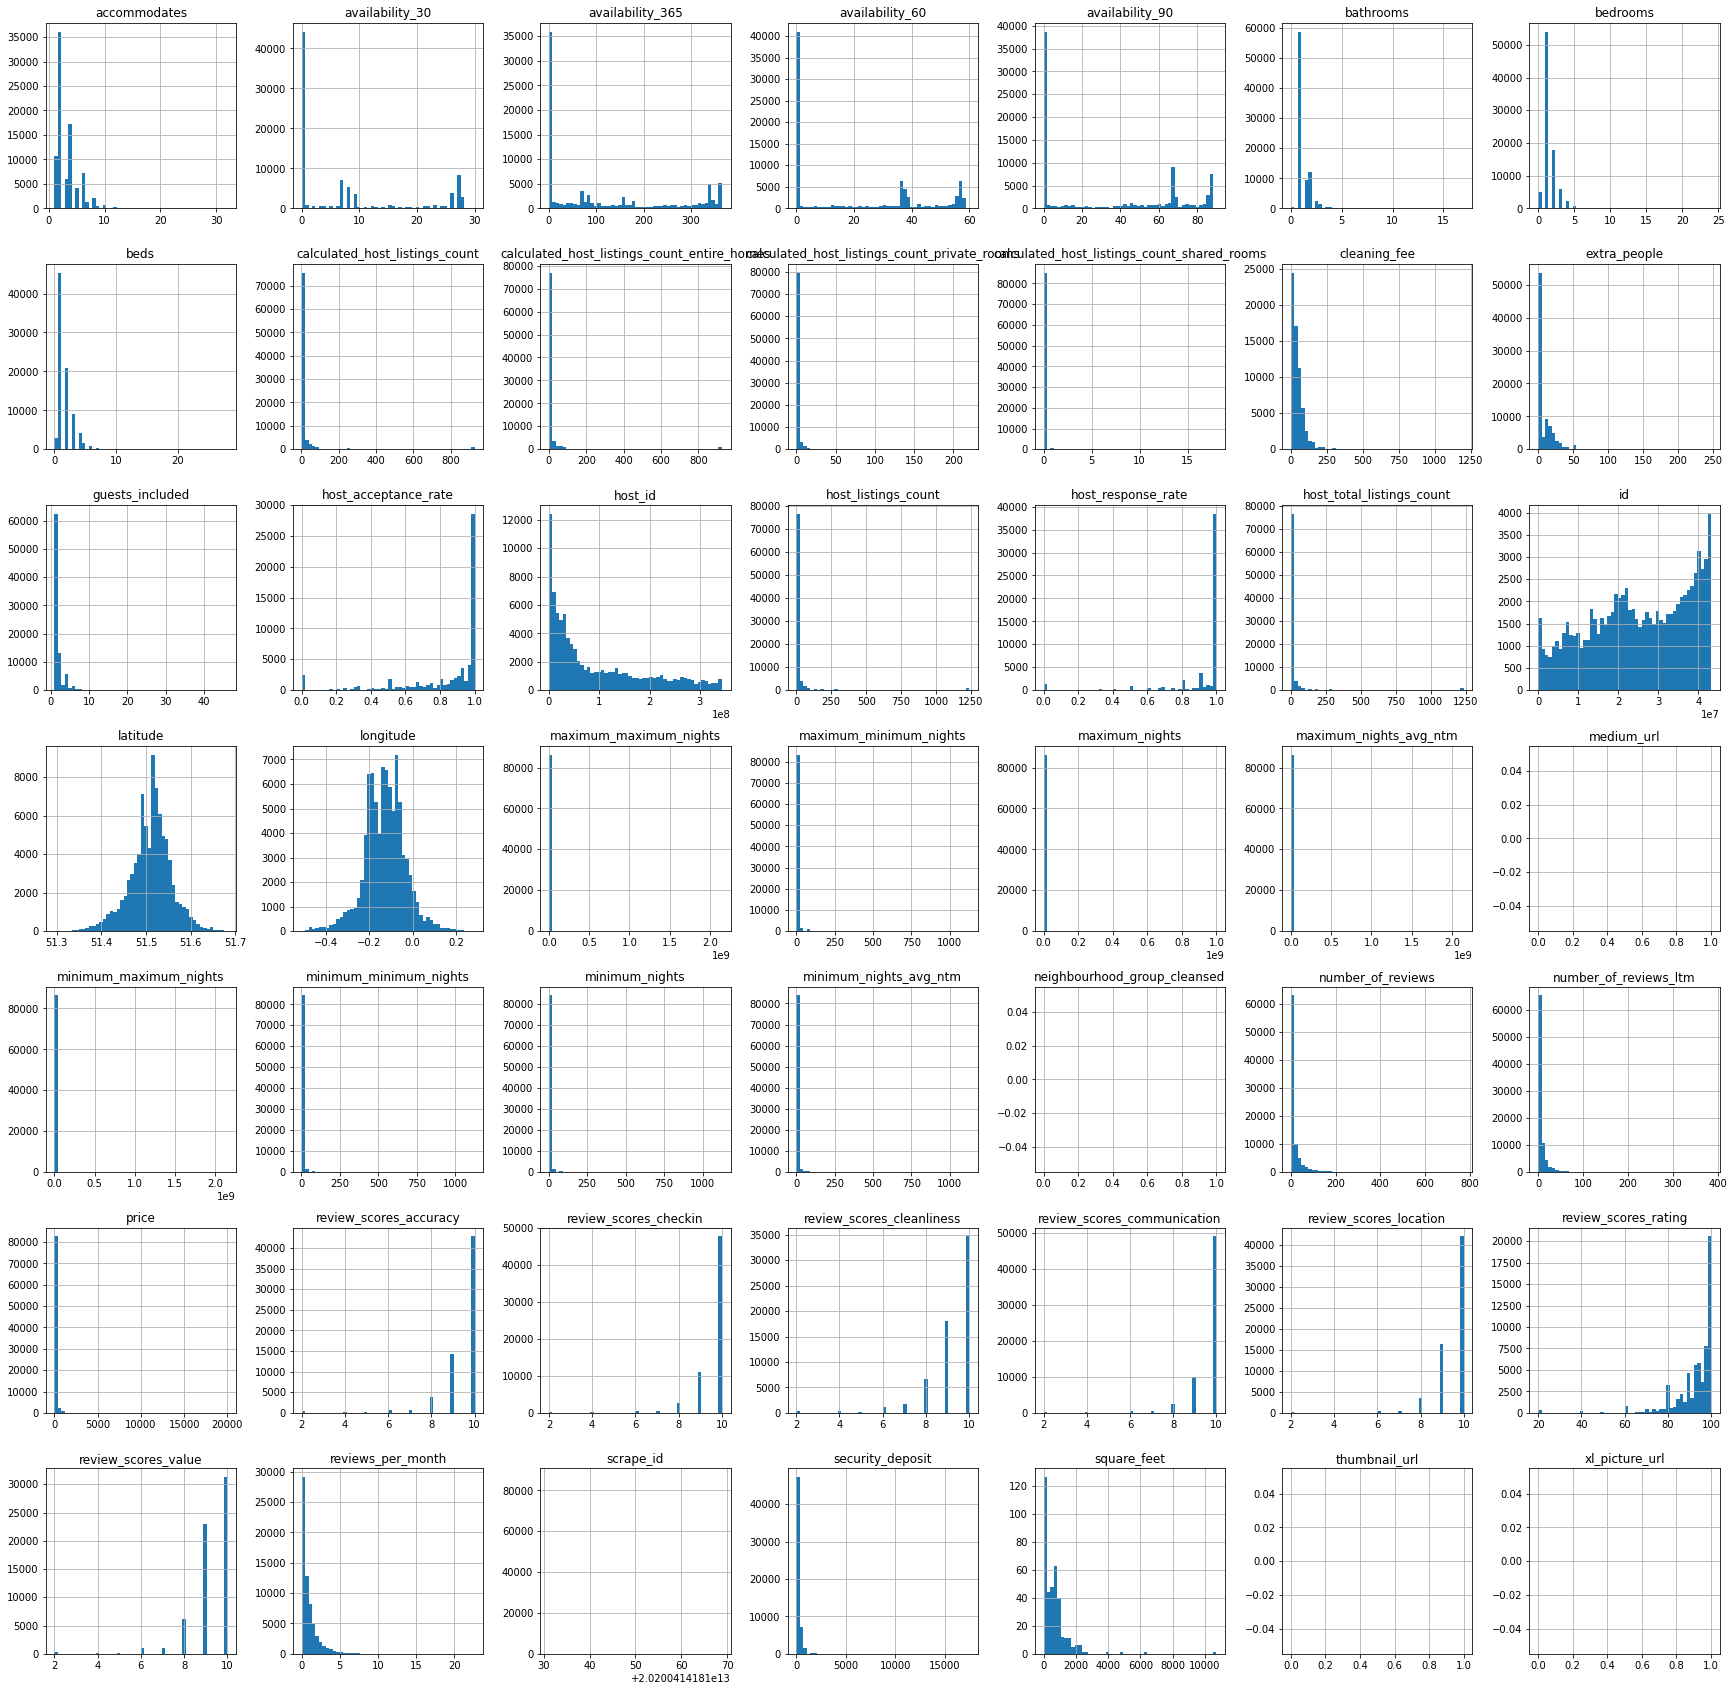

In [10]:
df_listings.hist(bins=50, figsize=(30,30))
plt.show()

### Removing Price Outliers

In [11]:
def find_outliers(df_listings):
    # Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(df_listings["price"], 25)
    
    #Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(df_listings["price"],75)
    
    # Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = (Q3 - Q1) * 1.5
    
    # Display the outliers
    #print("Data points considered outliers for the feature '{}':".format("price"))
    filtered_data = df_listings[~((df_listings["price"] >= Q1 - step) & 
                                  (df_listings["price"] <= Q3 + step))].sort_values(by=["price"])
                                  
    #filtered_data["price"].hist()
    #outliers = filtered_data[filtered_data["price"] >= 1000.00]
    
    return filtered_data
                                  
                                  
outliers = find_outliers(df_listings).index
                                  
df_listings = df_listings.drop(df_listings.index[outliers]).reset_index(drop = True)

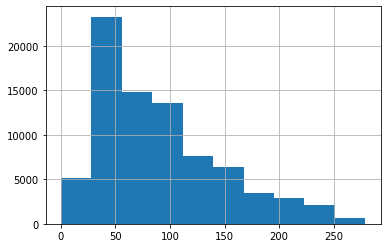

In [12]:
df_listings["price"].hist()

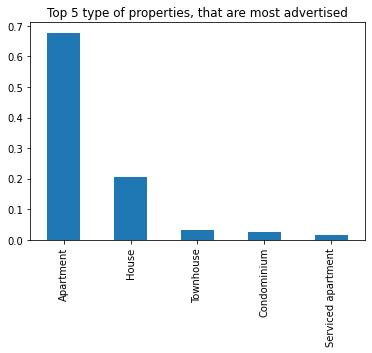

In [13]:
neighbourhood_vals = df_listings['property_type'].value_counts()

# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

(neighbourhood_vals[0:5]/df_listings.shape[0]).plot(kind="bar");
plt.title("Top 5 type of properties, that are most advertised");

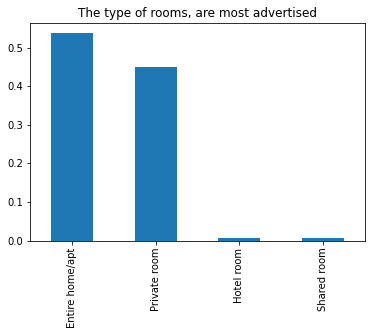

In [14]:
room_vals = df_listings['room_type'].value_counts()

# The below should be a bar chart of the proportion of individuals in each professional category if your status_vals
# is set up correctly.

(room_vals/df_listings.shape[0]).plot(kind="bar");
plt.title("The type of rooms, are most advertised");

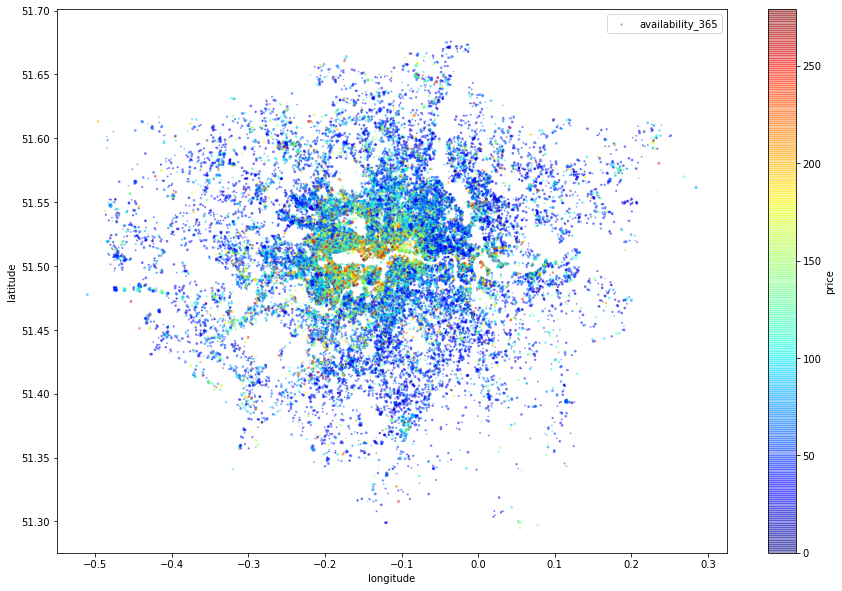

In [15]:
df_listings.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4, figsize=(15,10),
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c="price", cmap=plt.get_cmap('jet'), 
                 colorbar=True,
                 sharex=False)
plt.show()

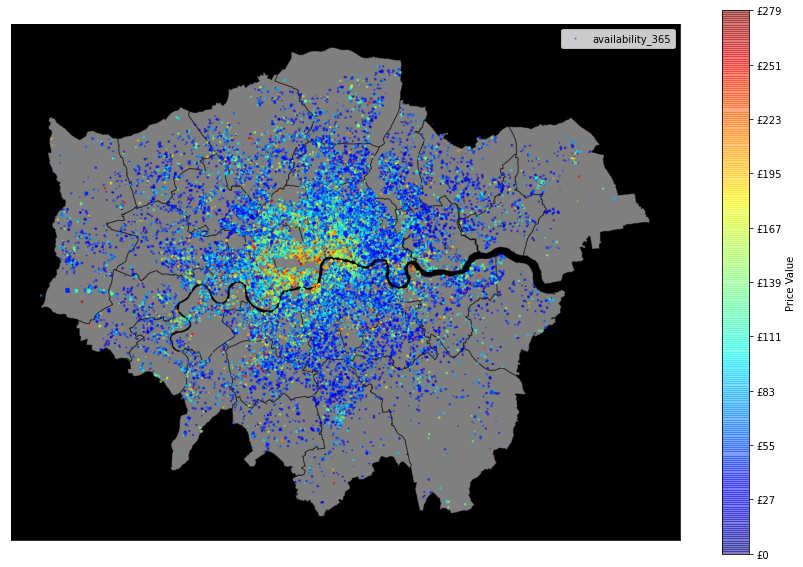

In [16]:
import geopandas as gpd

fig, ax = plt.subplots(1, 1, figsize=(15,10))

basemap = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')
basemap = basemap.to_crs(epsg=4326)


basemap = basemap.plot(alpha=0.5, edgecolor='k',color='White',figsize=(15,10),ax=ax)
basemap.set_facecolor('black')


x, y = df_listings['longitude'].values, df_listings['latitude'].values
basemap.scatter(x,y, alpha=0.5,
                 s=(df_listings["availability_365"])/100, label="availability_365", 
                 c=df_listings["price"], cmap=plt.get_cmap('jet'))


sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('jet'))
prices = df_listings["price"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = fig.colorbar(sm, ticks=tick_values/prices.max(), alpha=0.5)
cbar.ax.set_yticklabels(["£%d"% v for v in tick_values], fontsize=10)
cbar.set_label('Price Value', fontsize=10)

# Removing ticks
plt.xticks([]),
plt.yticks([])

plt.legend(fontsize=10)
#save_fig("availability_365_prices_scatterplot")
plt.show()

##### What are Airbnb current challanges?

### Question 1
- What is the average price of the listings, for the different location within London?

In [17]:
price_df = df_listings[df_listings['price'].isnull() == False]

In [18]:
price_df['neighbourhood_cleansed'].value_counts()[:5]

Tower Hamlets             8062
Westminster               8039
Hackney                   6022
Camden                    5619
Kensington and Chelsea    4976
Name: neighbourhood_cleansed, dtype: int64

In [19]:
nb_price_avg = price_df.groupby('neighbourhood_cleansed', as_index=False).mean()
nb_price_avg = pd.DataFrame(nb_price_avg).sort_values(by='price', ascending=False)

In [20]:
nb_price_avg = nb_price_avg.rename(columns={'neighbourhood_cleansed':'Neighbourhood','price': 'Avg Price'})

In [21]:
def chart_plot(data, x_label, y_label):
    
    plt.figure(figsize=(10,5))

    sns.set(style="whitegrid")
    chart = sns.barplot(x=x_label, y=y_label, data=data)

    chart.set_xticklabels(
        chart.get_xticklabels(), 
        rotation=60, 
        horizontalalignment='right',
        fontweight='light',
        fontsize='medium', 
        rotation_mode='anchor'
    )

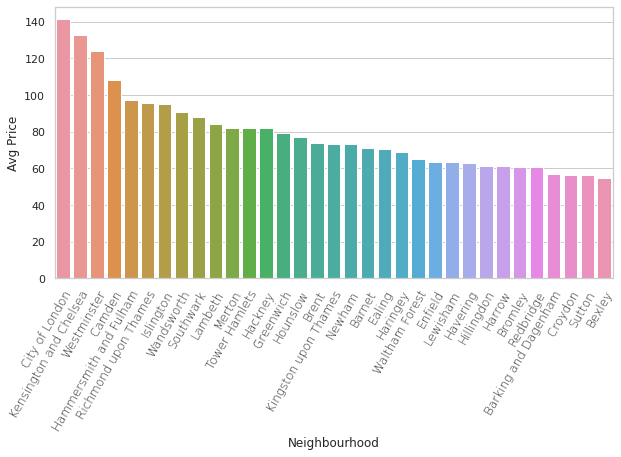

In [22]:
chart_plot(nb_price_avg,"Neighbourhood", "Avg Price")
#save_fig("Neighbourhood_av_price_histogram_plots")

### Question 2

- What types of verifications are hosts using? How long did it take them to respond?

In [23]:
verifications_df = df_listings[df_listings['host_verifications'].isnull() == False]

In [24]:
verifications_df = verifications_df[verifications_df['host_verifications'] != '[]']

In [25]:
def verifications_types(column):
    verifications_dict = {}
    temp = []

    for i in column:
        temp.append(eval(i))
    
    for i in temp:
        try:
            for j in i:
                if j not in verifications_dict:
                    verifications_dict[j] = 1
                else:
                    verifications_dict[j] += 1
        except:
            continue
            
    return verifications_dict
        
verifications_types = verifications_types(verifications_df['host_verifications'])

In [26]:
for k,v in verifications_types.items():
    verifications_types[k] = round(v / verifications_df.shape[0] * 100, 3)

In [27]:
verifications_types = pd.DataFrame.from_dict(verifications_types,orient='index',columns=['A']).reset_index()
verifications_types = verifications_types.rename(columns={'index':'Verification Type','A': '% of listings'})
verifications_types = verifications_types.sort_values(by='% of listings', ascending=False)

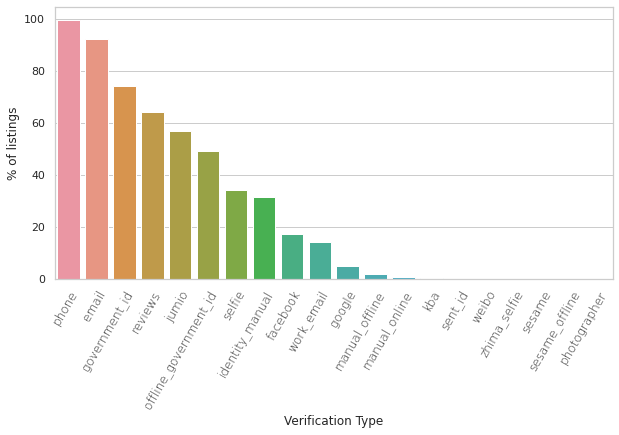

In [28]:
chart_plot(verifications_types,"Verification Type", "% of listings")
#save_fig("Verification_type_price_histogram_plots")

### Question 3
- What amenities are most used and does the count of amenities affect the review? 

In [29]:
#def convert_to_num(column):
    
#    column = column.str.replace('{', '', regex=True).replace('}', '', regex=True).replace('\"', '', regex=True)
#    column = column.str.split(',')
        
#    return column


#df['amenities'] = convert_to_num(df['amenities'])

### Question 4
- What features assist in the pricing of a listing? 
    - Could the price be predicted?
    - importance of the features, rank features

#### Preparing data

In [30]:
def drop_columns(df_listings):
    
    # Dropping Columns that aren't needed
    regex_list = ['url','id','scraped','first_review','last_review']
    for i in regex_list:
        df_listings = df_listings[df_listings.columns.drop(list(df_listings.filter(regex=i)))]
        
    df_listings = df_listings.drop(columns=['name','summary','space','description','neighborhood_overview','notes',
                                            'transit','access','interaction','house_rules','host_name','host_about',
                                            'latitude','longitude','host_since','host_neighbourhood','street',
                                            'neighbourhood','market','host_location','city','state','zipcode',
                                            'smart_location','country_code','country','amenities', 'host_verifications'])
    
    # remove columns with 70% or high with missing data
    col_nulls = set(df_listings.columns[df_listings.isnull().mean()>0.70])
    df_listings = df_listings.drop(list(col_nulls), axis=1)
    
    return df_listings

df_listings = drop_columns(df_listings)

In [31]:
def fill_na_data(df_listings):
    
    # filling float or int columns with the mean value of the column
    num_vars = df_listings.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df_listings[col].fillna((df_listings[col].mean()), inplace=True)
        
        
    # filling the categorial columns with text
    df_listings['host_response_time'].fillna('No Response', inplace=True)
    df_listings['host_is_superhost'].fillna('f', inplace=True)
    df_listings['host_has_profile_pic'].fillna('f', inplace=True)
    df_listings['bed_type'].fillna('Unknown', inplace=True)
    
    return df_listings

df_listings = fill_na_data(df_listings)

In [32]:
# Removing rows that do not have a price
df = df_listings.dropna(subset=["price"])

In [33]:
# Dummy the categorical variables
cat_vars = df.select_dtypes(include=['object']).copy().columns
for var in  cat_vars:
    # for each cat add dummy var, drop original column
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var],
                                                         prefix=var, prefix_sep='_', drop_first=True)], axis=1)

#### Building the Model

In [34]:
X = df.drop('price', axis = 1)
y = df['price']

In [35]:
#X.shape

In [36]:
#X_new = SelectKBest(chi2, k=200).fit_transform(X, y)

In [37]:
#X_new.shape

In [38]:
#split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

#### Fittng the training data with various models

In [39]:
def model_fit(model,X,y):
    
    model.fit(X,y)
    
    return model

In [40]:
def model_rmse(model, X_test, y_test):
    predictions = model.predict(X_test) 
    mse = mean_squared_error(y_test,predictions) 
    rmse = np.sqrt(mse) 
    
    return rmse

In [41]:
lin_reg = LinearRegression()
model_fit(lin_reg, X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [42]:
model_rmse(lin_reg, X_test, y_test)

34.47354910209486

In [43]:
tree_reg = DecisionTreeRegressor()
model_fit(tree_reg, X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [44]:
model_rmse(tree_reg, X_test, y_test)

44.40969097879071

In [45]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()

In [46]:
model_fit(forest_reg, X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [47]:
model_rmse(forest_reg, X_test, y_test)

31.489024810647273

#### Finding the scores, mean and standard variations of the different models

In [48]:
from sklearn.model_selection import cross_val_score

In [49]:
def display_scores(model,X_train,y_train):
    
    scores = cross_val_score(model,X_train,y_train,scoring = "neg_mean_squared_error",cv = 10)
    model_rmse_scores = np.sqrt(-scores) 
    
    print("Scores:",model_rmse_scores)
    print("Mean:",model_rmse_scores.mean())
    print ("Standard deviation:",model_rmse_scores.std())

display_scores(lin_reg,X_train,y_train)

Scores: [3.51002365e+01 3.43449692e+01 3.42741292e+01 3.60706851e+04
 3.52276716e+01 3.48671441e+01 3.48130976e+01 3.48466433e+01
 1.14062277e+03 1.15969302e+03]
Mean: 3861.4474818930116
Standard deviation: 10745.421988452379


In [50]:
display_scores(tree_reg,X_train,y_train)

Scores: [44.60645525 43.77650252 45.69408069 44.80777798 45.67547715 44.30073911
 44.72467886 44.91579427 44.30953871 45.28812973]
Mean: 44.80991742699924
Standard deviation: 0.5828456110851767


In [51]:
display_scores(forest_reg,X_train,y_train)

Scores: [31.83496632 31.23572474 31.82427677 31.91980474 32.33144277 31.89269731
 32.21724533 32.35931264 30.80760372 31.61212968]
Mean: 31.80352040428586
Standard deviation: 0.4617945366373874


#### GridSearchCV - Finding the best parameters

In [57]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor


def grid_search(X_train, y_train):
    """ Performs grid search over parameters for a 
        radom fores regressor trained on the input data [X, y]. """
    
    # Create cross-validation sets from the training data
    cv_sets = ShuffleSplit(n_splits = 10, test_size = 0.20, random_state = 0)

    # Create a RandomForestRegressor object
    regressor = RandomForestRegressor()

    # Create a dictionary for the parameter 'max_depth' with a range from 1 to 10
    param_grid = [ 
        { 'n_estimators':[ 50 , 100 , 150, 200], 'max_features':[ 6, 8, 10, 12]}, 
        { 'bootstrap':[False], 'n_estimators':[ 50 , 100 , 150, 200], 'max_features':[ 6, 8, 10, 12]},
    ]

    # Create the grid search object #scoring=scoring_fnc
    grid_search = GridSearchCV(regressor, param_grid, cv=cv_sets, 
                               scoring='neg_mean_squared_error',
                               return_train_score=True)

    # Fit the grid search object to the data to compute the optimal model
    grid_search.fit(X_train, y_train)
    
    best_params = grid_search.best_params_
    cv_results = grid_search.cv_results_
    feature_importances = grid_search.best_estimator_.feature_importances_
    final_model = grid_search.best_estimator_
    
    # Return the optimal model after fitting the data
    return best_params, cv_results, feature_importances, final_model

In [ ]:
# Fit the training data to the model using grid search
best_params, cv_results, feature_importances, final_model = grid_search(X_train, y_train)

# Produce the best params
print(best_params)

In [ ]:
# Finding the best evaluation scores
for mean_score, params in zip (cv_results["mean_test_score"], cv_results["params"]):
    print(round(np.sqrt(-mean_score),2),params)

In [55]:
# Finding the feature importance
# feature_importances

In [ ]:
# Display the feature importance scores
# extra_attribs = ["rooms_per_hhold","pop_per_hhold","bedrooms_per_room"]
# cat_encoder = full_pipeline.named_transformers_ ["cat"]
# cat_one_hot_attribs = list(cat_encoder.categories_[0])
# attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances,X_train.columns),reverse = True) 

In [56]:
# Evaluate the system on the test set
model_rmse(final_model, X_test, y_test)

31.799428150498102